# Lab 6
Noam Yan

## Setup

In [1]:
import pickle
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# 1m fake data, poisson distribution with mean = 100.
num = int(1e6)
bg = stats.poisson.rvs(100,size=num)

## Problem 1

In [3]:
threshold = stats.poisson.isf(q=stats.norm.sf(5),mu=100,loc=0)
print("The 5-sigma threshold is %.1d." %threshold)

The 5-sigma threshold is 154.


##  Problem 2
I have to choose 8 sigma because other values would result in nan for signal.

In [4]:
signal = stats.poisson.isf(q=stats.norm.sf(8),mu=100,loc=0)
print("My signal value is %.2f."%signal)
signal = np.repeat([signal],bg.shape[0])

My signal value is 190.00.


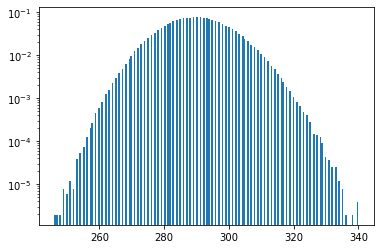

In [5]:
plt.hist(bg+signal,180,density=True)
plt.yscale('log')
plt.show()

a) This is a P(d|s) plot. It tells me the distribution of data given signal=190.<br><br>
b) To know whether the observed signal is biased, we need to check whether the peak is at the expected position which, in this case, is the mean of background + signal = 100+190 = 290.

In [6]:
p,b = np.histogram(bg+signal,180,density=True)
leftBound = b[np.where(p==p.max())]
rightBound = b[np.where(p==p.max())[0]+1]

print("The bin of peak value is at [%.2f , %.2f]."%(leftBound,rightBound))

The bin of peak value is at [289.87 , 290.39].


The expected value 290 falls into the peak bin, we therefore can conclude that the observed signal is unbiased.<br>
It should be asymmetric, because Poisson distribution does not allow negative values. Though there is a very little chance to have values far away from mean, the distribution lacks of a left tail. So it is asymetirc. In this case, the P(d|s) is shifted Poisson to the right 190 units, so it inherit the property of symmetry -- it is asymetric.

# Problem 3


In [7]:
# We are not able to calculate the 30-sigma value, so I simply use 300 insted.
sigRange = stats.uniform.rvs(loc=0, scale=300, size=num)

data = bg + sigRange

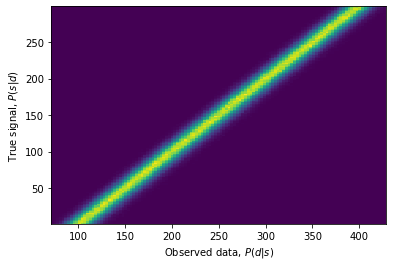

In [8]:
bins = 150
signaledges = np.linspace(0,300,bins)
dataedges = np.linspace(70,430,int(bins*300/(430-70)))

Psd, xrange, yrange= np.histogram2d(data,sigRange, bins=[dataedges,signaledges], density=True)

datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2
plt.pcolormesh(datacenters,signalcenters,Psd.T)
plt.ylabel('True signal, $P(s|d)$')
plt.xlabel('Observed data, $P(d|s)$')
plt.show()

a) I am simulating observations of data injected with different values of signals who ranges from 0 to 300.<br>
b) Let's extract the slice where signal=190.

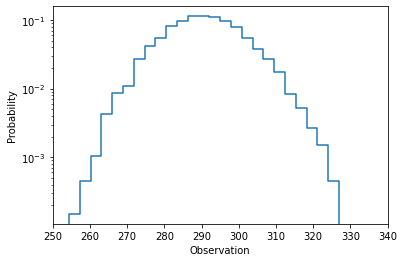

In [9]:
index = np.digitize(190,yrange)
likelyhood = Psd[:,index]
likelyhood = np.squeeze(likelyhood)
# Renormalize
ratio = 1 / np.sum(likelyhood)
likelyhood = likelyhood*ratio

plt.step(datacenters,likelyhood)
plt.ylabel('Probability')
plt.xlabel('Observation')
plt.xlim([250,340])
plt.yscale('log')
plt.show()

This plot is not exactly the same as the one in Problem 2, but they are consistent in symmetry and the property of bias. We can assert that we get the same answer.

c) The 5-sigma is 154. Here I choose 250 as the observed data value.

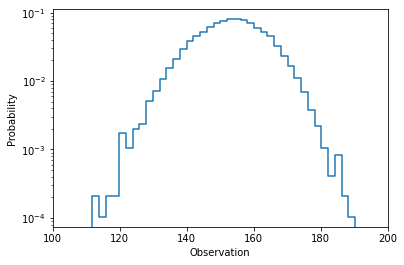

In [10]:
index = np.digitize(250,xrange)
posterior = Psd[index,:]
# Renormalize
ratio = 1 / np.sum(posterior)
posterior = posterior * ratio

plt.step(signalcenters,posterior)
plt.ylabel('Probability')
plt.xlabel('Observation')
plt.xlim([100,200])
plt.yscale('log')
plt.show()

This plot shows distribution of signal given data intensity=250. we can see the peak is at about 155. It means that we are the most likely to find the expected signal of 155.
<br><br>
d) First we need to find the most probable signal (peak). The probability of 1-sigma is about 34.1% .

In [11]:
center = np.where(posterior==posterior.max())[0]

total = 0
pointer = center[0]
while total < .341:
    pointer += 1
    total += posterior[pointer]
pos_1sig = signalcenters[pointer]

total = 0
pointer = center[0]
while total < .341:
    pointer -= 1
    total += posterior[pointer]
neg_1sig = signalcenters[pointer]

print("X = %.2f ."%(signalcenters[center]))
print("Y = +%.2f"%(pos_1sig-signalcenters[center]))
print("Z = -%.2f"%abs(neg_1sig-signalcenters[center]))


X = 154.03 .
Y = +12.08
Z = -12.08


Therefore the 1σ uncertainty is $154.03^{+12.08}_{-12.08}$ .

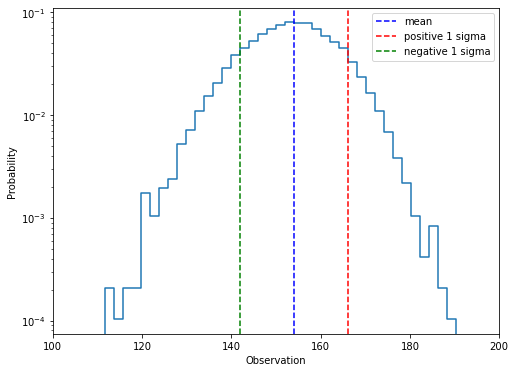

In [12]:
plt.rcParams["figure.figsize"] = (8,6)
plt.step(signalcenters,posterior)
plt.axvline(signalcenters[center],color='b', linestyle='--',label='mean')
plt.axvline(pos_1sig, color='r', linestyle='--',label='positive 1 sigma')
plt.axvline(neg_1sig, color='g', linestyle='--',label='negative 1 sigma')

plt.ylabel('Probability')
plt.xlabel('Observation')
plt.xlim([100,200])
plt.legend()
plt.yscale('log')
plt.show()

e) Let's compare the position of peak and the expected signal value.

In [13]:
leftBound = signaledges[np.where(posterior==posterior.max())]
rightBound = signaledges[np.where(posterior==posterior.max())[0]+1]
print("The bin of peak value is at [%.2f , %.2f]."%(leftBound,rightBound))
print("And the expected peak is at 150 which result from (250-100).")
print("Bias = %.2f."%(signalcenters[center]-150))

The bin of peak value is at [153.02 , 155.03].
And the expected peak is at 150 which result from (250-100).
Bias = 4.03.


The observed signal is biased and symmetric.<br>
The interesting thing is the property of symmetry varies as I run the code multiple times. In most times, the distribution is asymmetry.